In [60]:
directory = './Tweets.csv/'
import pandas as pd
import numpy as np
from help import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daniel.DESKTOP-
[nltk_data]     JL0PCLC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
twitter = pd.read_csv(directory + 'Tweets.csv')

In [4]:
twitter.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [6]:
twitter.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
twitter['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

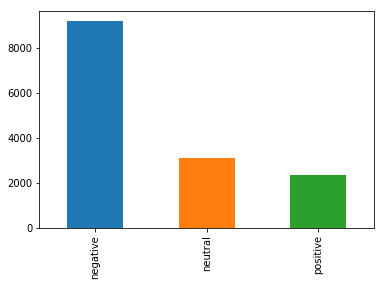

In [13]:
twitter['airline_sentiment'].value_counts().plot.bar()

In [42]:
twitter['Proposed_Sentiment'] = twitter['text'].apply(lambda x: sentiment.polarity_scores(x)['compound'])

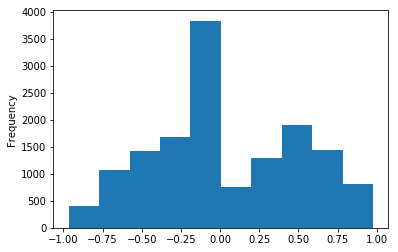

In [45]:
twitter['Proposed_Sentiment'].plot.hist()

In [52]:
twitter['Proposed_Sentiment_Classes'] = (twitter['Proposed_Sentiment'] == 0).replace({True:'Neutral'})
twitter['Proposed_Sentiment_Classes'].loc[twitter['Proposed_Sentiment'] < 0] = 'Negative'
twitter['Proposed_Sentiment_Classes'].loc[twitter['Proposed_Sentiment'] > 0] = 'Positive'

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


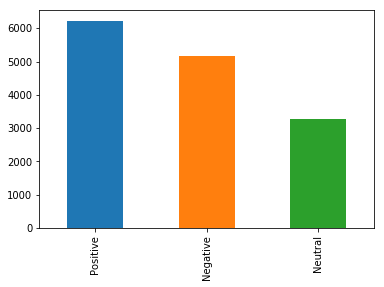

In [56]:
twitter['Proposed_Sentiment_Classes'].value_counts().plot.bar()

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer()
counter.fit(twitter['text'].values)

counted_bag_of_words = counter.transform(twitter['text'].values)

In [69]:
twitter['Y'] = twitter['airline_sentiment'].replace({'neutral':0, 'negative':-1, 'positive':1})

In [98]:
sum(twitter['Proposed_Sentiment_Classes'].str.lower() == twitter['airline_sentiment']) / len(twitter['airline_sentiment'])

0.5465163934426229

In [71]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(counted_bag_of_words, twitter['Y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
np.round(model.predict(counted_bag_of_words))

array([ 0.,  1.,  0., ...,  0., -1., -0.])

In [75]:
(np.round(model.predict(counted_bag_of_words)) == twitter['Y']).sample(10)

3812      True
10472     True
2609      True
12957     True
296       True
3662     False
8812      True
9815      True
3847      True
3247      True
Name: Y, dtype: bool

In [77]:
sum(np.round(model.predict(counted_bag_of_words)) == twitter['Y'])   / len(twitter['Y'])

0.9340846994535519

In [78]:
from sklearn.model_selection import train_test_split as holdout

x_train, x_test, y_train, y_test = holdout(counted_bag_of_words, twitter['Y'], test_size = 0.3, random_state = 0)

In [79]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
sum(np.round(model.predict(x_train)) == y_train)   / len(y_train)

0.9603825136612022

In [85]:
sum(np.round(model.predict(x_test)) == y_test)   / len(y_test)

0.3638433515482696

In [90]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')

In [91]:
model_log.fit(x_train, y_train)
sum(np.round(model_log.predict(x_train)) == y_train)   / len(y_train)

0.9584309133489461

In [92]:
sum(np.round(model_log.predict(x_test)) == y_test)   / len(y_test)

0.7953096539162113

In [104]:
np.argmax(model_log.predict_proba(x_test), 1)

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [116]:
model_log.predict(x_test)

array([-1,  0, -1, ..., -1, -1,  0], dtype=int64)

In [158]:
model_log.predict_proba(x_test)[0:10]

array([[9.82754691e-01, 1.15711941e-02, 5.67411489e-03],
       [2.87465029e-01, 7.04531819e-01, 8.00315234e-03],
       [9.77038924e-01, 1.93304588e-02, 3.63061685e-03],
       [1.93593137e-01, 7.88695903e-01, 1.77109595e-02],
       [4.20832291e-01, 3.62714023e-02, 5.42896306e-01],
       [2.39014536e-01, 7.42777952e-01, 1.82075123e-02],
       [2.49896619e-01, 6.79255609e-01, 7.08477719e-02],
       [9.95192929e-01, 3.50790978e-03, 1.29916106e-03],
       [9.88870632e-01, 1.02354155e-02, 8.93952313e-04],
       [9.99825829e-01, 1.66429036e-04, 7.74208890e-06]])

In [157]:
model_log.predict_proba(x_test) * np.matrix([-1,0,1]).T[0:10]

matrix([[-0.97708058],
        [-0.27946188],
        [-0.97340831],
        ...,
        [-0.99935311],
        [-0.70335745],
        [ 0.03854431]])

In [118]:
result = model_log.predict_proba(x_test) * np.matrix([-1,0,1]).T

In [150]:
(np.array((np.round(result).T))[0] == y_test).head(10)

13983     True
14484    False
6403      True
9653     False
13268    False
2384      True
9613     False
11612     True
9252      True
13923     True
Name: Y, dtype: bool

In [152]:
(np.array((np.round(result).T))[0] == y_test).sum() / len(y_test)

0.7657103825136612

In [154]:
train_result = model_log.predict_proba(x_train) * np.matrix([-1,0,1]).T

In [156]:
train_result[0:10]

matrix([[ 0.37044867],
        [-0.98596526],
        [-0.99996566],
        [-0.93390129],
        [-0.01131766],
        [-0.86012213],
        [-0.99524993],
        [ 0.58936745],
        [ 0.43645904],
        [-0.98581392]])

In [163]:
twitter['text'].loc[y_train.index].head(10)

12647    @AmericanAir no space in my seat but thanks to...
3652     @united A change fee of $200. Same exact fligh...
11570    @USAirways Worst experience ever. Unable 2 hel...
1278     @United how is it that I book a flight with a ...
6052                    @SouthwestAir okay just signed up!
12465    @AmericanAir yes it is in Dulles and I need it...
10408    @USAirways From here on out when I can at all ...
3658     @united \nI will admit, you've been rather goo...
1855     @united just touched down in Miami - not too f...
9369     @USAirways Thanks but when I asked for a chang...
Name: text, dtype: object

In [178]:
complaint_rank = pd.DataFrame(twitter['text'].loc[y_train.index])
complaint_rank['tweet_created'] = twitter['tweet_created'].loc[y_train.index]
complaint_rank.tail(5)

,text,tweet_created
13123,@AmericanAir followback,2015-02-23 10:58:58 -0800
3264,@united thanks for the help. Wish the phone re...,2015-02-19 16:13:17 -0800
9845,@usairways the. Worst. Ever. #dca #customerser...,2015-02-22 15:43:24 -0800
10799,@nrhodes85: look! Another apology. DO NOT FLY ...,2015-02-20 12:09:15 -0800
2732,@united you are by far the worst airline. 4 pl...,2015-02-20 16:24:49 -0800


In [179]:
complaint_rank['sentiment'] = train_result

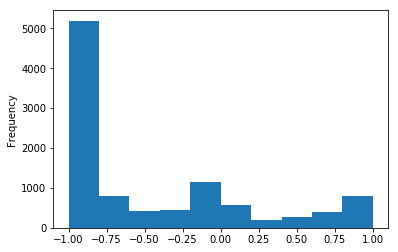

In [180]:
complaint_rank['sentiment'].plot.hist()

In [181]:
complaint_rank['sentiment'].sort_values()[0:10]

1214    -1.000000
13587   -1.000000
9740    -1.000000
10249   -1.000000
11265   -1.000000
1374    -0.999999
13708   -0.999999
912     -0.999999
13986   -0.999999
13071   -0.999999
Name: sentiment, dtype: float64

In [183]:
complaint_rank.sort_values(by = 'sentiment', inplace = True)

In [209]:
complaint_rank.iloc[[0,1,3,5,5000,6000,7000,8000,9000,10000,-1]].style.bar(subset = ['sentiment'], color=['red', 'green'], align='mid')

,text,tweet_created,sentiment
1214,"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!",2015-02-23 07:31:10 -0800,-1
13587,"@AmericanAir not only did you Cancelled Flight our flight from JFK and delay us by 29 hours, you've now lost 2 of our bags. Worst airline ever.",2015-02-23 03:15:29 -0800,-1
10249,"@USAirways worst experience with you. Cancelled Flightled flight, no voucher and no luggage because ""ramp was broken."" No other ramps in Charlotte??",2015-02-22 03:30:44 -0800,-1
1374,"@united after a Cancelled Flighted flight, and 2 delays, you lost my luggage AGAIN! You're the WORST! Disgraceful! Awful company, horrible service!",2015-02-22 22:52:01 -0800,-0.999999
12818,@AmericanAir I bought a plane ticket 2 months ago and still haven't received my flight info and ticket in my email when it will come?,2015-02-23 15:55:12 -0800,-0.825278
6813,@JetBlue Thank you for credits. However; I submitted complaints about the property on vacation package. Hope you listen!,2015-02-24 07:05:38 -0800,-0.597935
7020,NO“@JetBlue: Our fleet's on fleek. http://t.co/UgFCKErmrW”,2015-02-23 12:12:39 -0800,-0.159743
4735,@SouthwestAir to start 2xdaily #B737-700 flights from #OrangeCounty to #Portland OR on 8AUG #avgeek,2015-02-23 08:03:38 -0800,-0.0016144
6430,@SouthwestAir On my flight today from RSW to GRR I was able to snag a free SW Agent to check for me. It looks like we are (finally) all set.,2015-02-17 17:49:30 -0800,0.577455
12960,"@AmericanAir thank you, truly appreciate the help, just sent a DM",2015-02-23 13:32:32 -0800,0.968223


In [210]:
complaint_rank['Absolute_Value'] = np.abs(complaint_rank['sentiment'])

In [212]:
complaint_rank['Absolute_Value'].sample(5)

4357     0.798928
4474     0.847074
10218    0.932986
12529    0.999824
11927    0.517339
Name: Absolute_Value, dtype: float64

In [214]:
complaint_rank.iloc[[0,1,3,5,5000,6000,7000,8000,9000,10000,-1]].style.bar(subset = ['Absolute_Value'], align='mid')

,text,tweet_created,sentiment,Absolute_Value
1214,"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!",2015-02-23 07:31:10 -0800,-1,1
13587,"@AmericanAir not only did you Cancelled Flight our flight from JFK and delay us by 29 hours, you've now lost 2 of our bags. Worst airline ever.",2015-02-23 03:15:29 -0800,-1,1
10249,"@USAirways worst experience with you. Cancelled Flightled flight, no voucher and no luggage because ""ramp was broken."" No other ramps in Charlotte??",2015-02-22 03:30:44 -0800,-1,1
1374,"@united after a Cancelled Flighted flight, and 2 delays, you lost my luggage AGAIN! You're the WORST! Disgraceful! Awful company, horrible service!",2015-02-22 22:52:01 -0800,-0.999999,0.999999
12818,@AmericanAir I bought a plane ticket 2 months ago and still haven't received my flight info and ticket in my email when it will come?,2015-02-23 15:55:12 -0800,-0.825278,0.825278
6813,@JetBlue Thank you for credits. However; I submitted complaints about the property on vacation package. Hope you listen!,2015-02-24 07:05:38 -0800,-0.597935,0.597935
7020,NO“@JetBlue: Our fleet's on fleek. http://t.co/UgFCKErmrW”,2015-02-23 12:12:39 -0800,-0.159743,0.159743
4735,@SouthwestAir to start 2xdaily #B737-700 flights from #OrangeCounty to #Portland OR on 8AUG #avgeek,2015-02-23 08:03:38 -0800,-0.0016144,0.0016144
6430,@SouthwestAir On my flight today from RSW to GRR I was able to snag a free SW Agent to check for me. It looks like we are (finally) all set.,2015-02-17 17:49:30 -0800,0.577455,0.577455
12960,"@AmericanAir thank you, truly appreciate the help, just sent a DM",2015-02-23 13:32:32 -0800,0.968223,0.968223


In [216]:
complaint_rank['tweet_created'] = pd.to_datetime(complaint_rank['tweet_created'])

In [217]:
complaint_rank.sort_values(by = 'tweet_created', inplace = True)

In [220]:
complaint_rank['date'] = complaint_rank['tweet_created'].dt.date

In [221]:
complaint_rank['date'].value_counts()

2015-02-23    2434
2015-02-22    1677
2015-02-24    1503
2015-02-20    1053
2015-02-21    1015
2015-02-18    1002
2015-02-19     906
2015-02-17     658
Name: date, dtype: int64

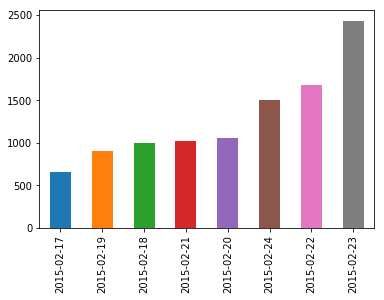

In [223]:
complaint_rank['date'].value_counts()[::-1].plot.bar()

In [231]:
complaint_rank.sort_values(by = ['date','Absolute_Value'], inplace = True, ascending = [1,0])

In [232]:
complaint_rank.iloc[0:15]

,text,tweet_created,sentiment,Absolute_Value,date
8900,"@JetBlue, I normally ❤️ you, but this Late Fli...",2015-02-17 19:20:57,-0.999998,0.999998,2015-02-17
8922,@JetBlue huge fan of great brands and people d...,2015-02-17 17:51:00,0.999997,0.999997,2015-02-17
4180,@united 3pm and my bags still not here. not ev...,2015-02-17 21:04:45,-0.999991,0.999991,2015-02-17
4222,@united waiting for flight 4567 to memphis. In...,2015-02-17 19:28:00,-0.999965,0.999965,2015-02-17
11872,@USAirways your service has been awful in Bost...,2015-02-17 16:11:57,-0.999965,0.999965,2015-02-17
11719,@USAirways I have now called 12 times in the l...,2015-02-17 21:38:38,-0.999955,0.999955,2015-02-17
4242,@united u lost my bag and would not refund my ...,2015-02-17 18:54:00,-0.999928,0.999928,2015-02-17
6640,"@SouthwestAir worst customer service, Terrible...",2015-02-17 18:13:33,-0.999901,0.999901,2015-02-17
11710,@USAirways how are you even still in business?...,2015-02-17 21:48:33,-0.999888,0.999888,2015-02-17
11853,@USAirways no we haven't because we've been in...,2015-02-17 16:51:31,-0.999876,0.999876,2015-02-17


In [255]:
each_day = []
for day in complaint_rank['date'].value_counts().index[::-1]:
    each_day.append(complaint_rank.loc[complaint_rank['date'] == day])

In [256]:
print(each_day[0][0:5])
print(each_day[-1][0:5])

                                                    text       tweet_created  \
8900   @JetBlue, I normally ❤️ you, but this Late Fli... 2015-02-17 19:20:57   
8922   @JetBlue huge fan of great brands and people d... 2015-02-17 17:51:00   
4180   @united 3pm and my bags still not here. not ev... 2015-02-17 21:04:45   
4222   @united waiting for flight 4567 to memphis. In... 2015-02-17 19:28:00   
11872  @USAirways your service has been awful in Bost... 2015-02-17 16:11:57   

       sentiment  Absolute_Value        date  
8900   -0.999998        0.999998  2015-02-17  
8922    0.999997        0.999997  2015-02-17  
4180   -0.999991        0.999991  2015-02-17  
4222   -0.999965        0.999965  2015-02-17  
11872  -0.999965        0.999965  2015-02-17  
                                                    text       tweet_created  \
1214   @united is the worst. Worst reservation polici... 2015-02-23 15:31:10   
13587  @AmericanAir not only did you Cancelled Flight... 2015-02-23 11:15:29 

In [257]:
max_replies = 50

In [258]:
each_day_limit = [x.iloc[0:max_replies] for x in each_day]

In [259]:
each_day_limit[0].sample(10)

,text,tweet_created,sentiment,Absolute_Value,date
4234,@united 45 minutes after arrival and no bags f...,2015-02-17 19:12:28,-0.999815,0.999815,2015-02-17
11741,@USAirways The airline is embarrassing itself....,2015-02-17 20:32:40,-0.998982,0.998982,2015-02-17
11716,@USAirways flight #654 sitting at JFK with del...,2015-02-17 21:45:22,-0.999789,0.999789,2015-02-17
4180,@united 3pm and my bags still not here. not ev...,2015-02-17 21:04:45,-0.999991,0.999991,2015-02-17
4261,@united Miserable trip ... lost bag Sat... fou...,2015-02-17 17:58:54,-0.999572,0.999572,2015-02-17
11719,@USAirways I have now called 12 times in the l...,2015-02-17 21:38:38,-0.999955,0.999955,2015-02-17
6683,@SouthwestAir I need to reschedule a flight an...,2015-02-17 17:20:44,-0.999109,0.999109,2015-02-17
6691,@SouthwestAir I've been on hold for an hour &a...,2015-02-17 17:09:13,-0.999849,0.999849,2015-02-17
8928,@JetBlue already spent $300 to stay at hotel l...,2015-02-17 17:31:42,-0.998730,0.998730,2015-02-17
4299,@united did not let me get on the IAH-HNL dire...,2015-02-17 16:49:42,-0.999283,0.999283,2015-02-17


In [261]:
random_limit = [x.sample(max_replies) for x in each_day]

In [262]:
random_limit[0].sample(10)

,text,tweet_created,sentiment,Absolute_Value,date
8884,@JetBlue Great thanks,2015-02-17 19:49:11,0.986352,0.986352,2015-02-17
8823,"@JetBlue flight 894, first officer not even at...",2015-02-17 22:43:55,-0.985448,0.985448,2015-02-17
4228,@united - could you please send me a phone # t...,2015-02-17 19:23:49,-0.923735,0.923735,2015-02-17
8816,@JetBlue so happy you can accommodate peanut/t...,2015-02-17 23:13:47,0.554784,0.554784,2015-02-17
6603,@SouthwestAir - I have spent 87 minutes (and c...,2015-02-17 19:05:33,-0.997983,0.997983,2015-02-17
11737,@usairways I’m cool with weather delays etc. B...,2015-02-17 20:47:31,-0.950913,0.950913,2015-02-17
4225,@united its 2015 and no power outlets at the s...,2015-02-17 19:27:03,-0.998556,0.998556,2015-02-17
4192,@united 3359 which you finally Cancelled Fligh...,2015-02-17 20:51:04,-0.896637,0.896637,2015-02-17
6599,@SouthwestAir an entire flight of luggage miss...,2015-02-17 19:13:27,-0.999205,0.999205,2015-02-17
4229,"@united I'm not this person, but I've been sit...",2015-02-17 19:23:36,-0.999666,0.999666,2015-02-17


In [263]:
for x in random_limit:
    print(x['Absolute_Value'].mean())

0.7555228329604298
0.6721540147629632
0.680640662793371
0.689360517972219
0.7231476771861238
0.7129304279791527
0.6622906609802134
0.6780685987470382


In [264]:
for x in each_day_limit:
    print(x['Absolute_Value'].mean())

0.9994022245423244
0.9993948472961798
0.9998098360417751
0.9997938029500617
0.9997415206406255
0.9998845979745475
0.9999594069683085
0.9999837453307886


In [266]:
scores = []
for x,y in zip(random_limit ,each_day_limit):
    scores.append(y['Absolute_Value'].mean() - x['Absolute_Value'].mean())

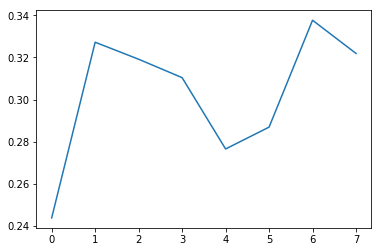

In [267]:
plt.plot(scores)